In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from scipy import spatial
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_1000_epochs_no_regularize_5_core.pkl')

In [4]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_dataset.pkl')

## Metrics

In [5]:
train_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_interactions.npz')
test_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_test_interactions.npz')

In [6]:
def hit_rate(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.any(pdf['rank'] <= k)
        )
    )

def precision(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.sum(pdf['rank'] <= k) / k
        )
    )

def recall(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.sum(pdf['rank'] <= k) / len(pdf)
        )
    )

In [7]:
results = model.predict_rank(test_interactions, train_interactions, num_threads=8)

In [8]:
results = coo_matrix(results)
results_pdf = pd.DataFrame(
    np.vstack((results.row, results.col, results.data)).T,
    columns=['reviewerID', 'asin', 'rank'],
    dtype=int
)

In [9]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [10]:
results_pdf['reviewerID'] = results_pdf['reviewerID'].map(user_mapping)
results_pdf['asin'] = results_pdf['asin'].map(item_mapping)

In [11]:
print('hit_rate@50: ', hit_rate(results_pdf))
print('precision@50: ', precision(results_pdf))
print('recall@50: ', recall(results_pdf))

  0%|          | 0/10000 [00:00<?, ?it/s]

hit_rate@50:  0.5038


  0%|          | 0/10000 [00:00<?, ?it/s]

precision@50:  0.026202000000000003


  0%|          | 0/10000 [00:00<?, ?it/s]

recall@50:  0.26202000000000003


## ABX utils

In [12]:
def analyse_ABX(path, tsne = None, pca = None):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 100))
    B = np.zeros((10000, 100))
    X = np.zeros((10000, 100))

    for i, test in tqdm(abx_tests.iterrows()):
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in tqdm(range(10000)):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    if tsne is not None:
        tsne_A = np.zeros((10000, 2))
        tsne_B = np.zeros((10000, 2))
        tsne_X = np.zeros((10000, 2))

        for i, test in tqdm(abx_tests.iterrows()):
            tsne_A[i, :] = tsne.loc[test["A"]]
            tsne_B[i, :] = tsne.loc[test["B"]]
            tsne_X[i, :] = tsne.loc[test["X"]]


        dist_tsne_A = ((tsne_A - tsne_X)**2).sum(axis=1)
        dist_tsne_B  = ((tsne_B - tsne_X)**2).sum(axis=1)

        cos_dist_tsne_A = np.zeros(10000)
        cos_dist_tsne_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_tsne_A[i] = spatial.distance.cosine(tsne_A[i, :], tsne_X[i, :])
            cos_dist_tsne_B[i] = spatial.distance.cosine(tsne_B[i, :], tsne_X[i, :])

    print("Eucl:")
    print("Score: ", (dist_A < dist_B).mean())
    if pca is not None:
        print("PCA score: ", (dist_pca_A < dist_pca_B).mean())
        print("PCA distance match: ", ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (dist_tsne_A < dist_tsne_B).mean())
        print("tSNE distance match: ", ((dist_A < dist_B) == (dist_tsne_A < dist_tsne_B)).mean())

    print("Cos:",)
    print("Score: ", (cos_dist_A < cos_dist_B).mean())
    if pca is not None:
        print("PCA score: ", (cos_dist_pca_A < cos_dist_pca_B).mean())
        print("PCA distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (cos_dist_tsne_A < cos_dist_tsne_B).mean())
        print("tSNE distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_tsne_A < dist_tsne_B)).mean())

In [13]:
items_embeddings = pd.DataFrame(model.item_embeddings)
items_embeddings = items_embeddings.rename(index=item_mapping)

user_embeddings = pd.DataFrame(model.user_embeddings)
embeddings = pd.concat([items_embeddings, user_embeddings], keys=['items', 'users'])
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

## ABX

In [14]:
analyse_ABX('/pio/scratch/1/recommender_systems/interim/ABX_tests/5_core.json', pca=pca)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.5819
PCA score:  0.6731
PCA distance match:  0.6022
Cos:
Score:  0.5957
PCA score:  0.6686
PCA distance match:  0.6279


## Embeddings PCA

In [15]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

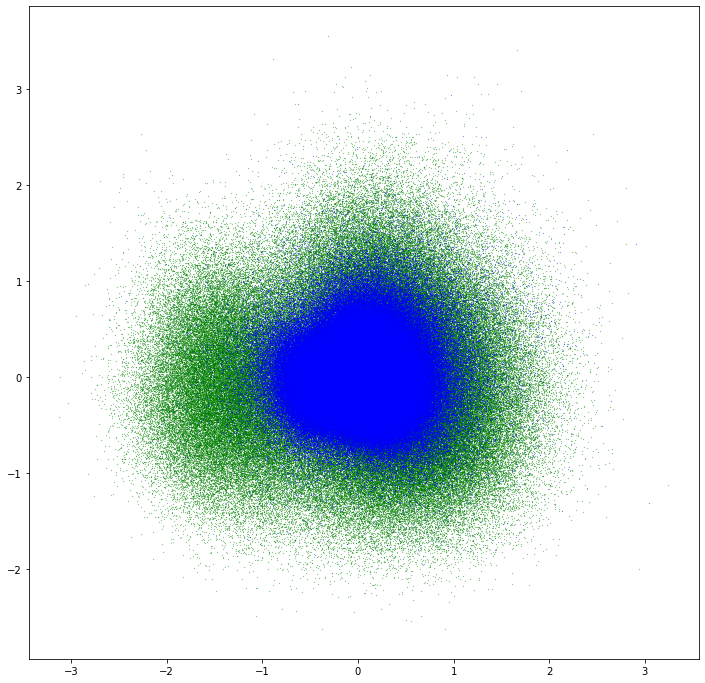

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [17]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [18]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [19]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [20]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


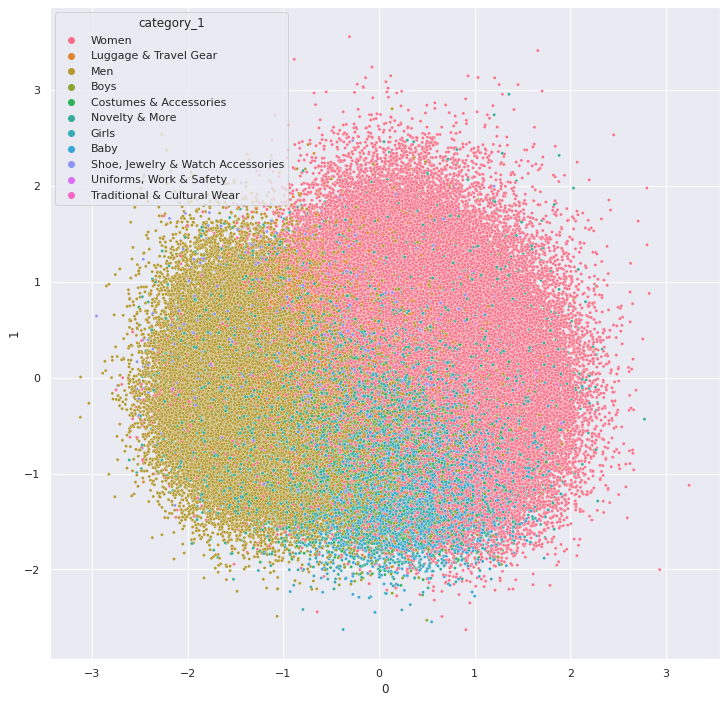

In [21]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

[(-5.0, 5.0), (-5.0, 5.0)]

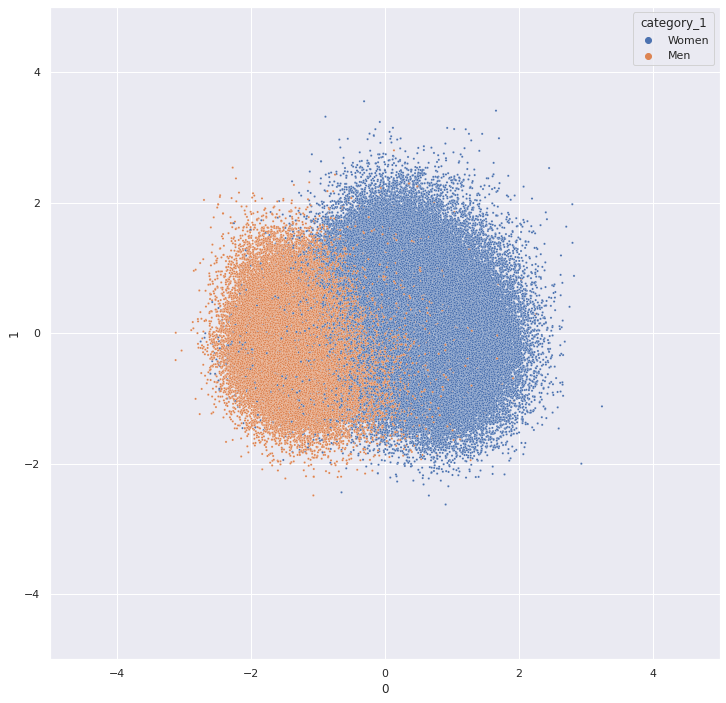

In [22]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5).set(xlim=(-5,5),ylim=(-5,5))

In [23]:
women_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Women']
men_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Men']

[(-5.0, 5.0), (-5.0, 5.0)]

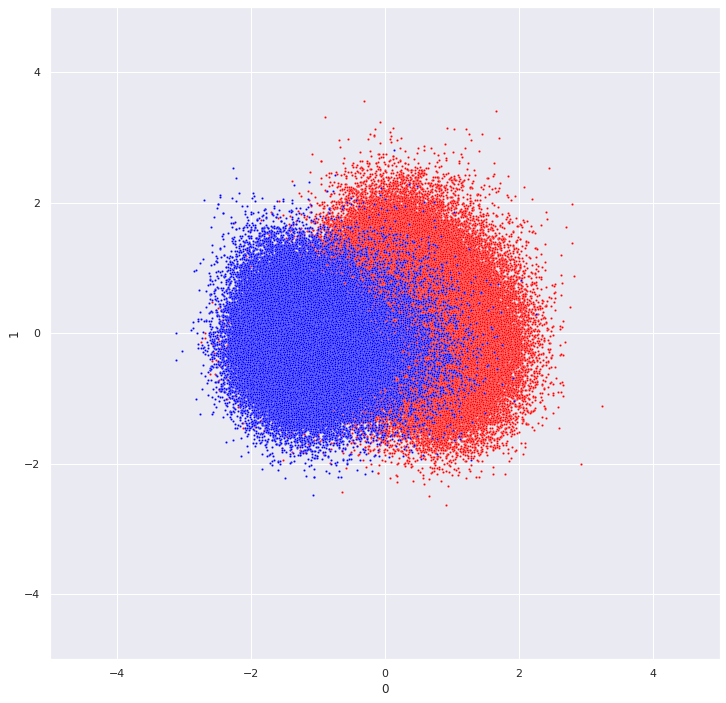

In [24]:
sns.scatterplot(x='0', y='1', data=women_embeddings, color='red', s=5).set(xlim=(-5,5),ylim=(-5,5))
sns.scatterplot(x='0', y='1', data=men_embeddings, color='blue', s=5).set(xlim=(-5,5),ylim=(-5,5))

[(-5.0, 5.0), (-5.0, 5.0)]

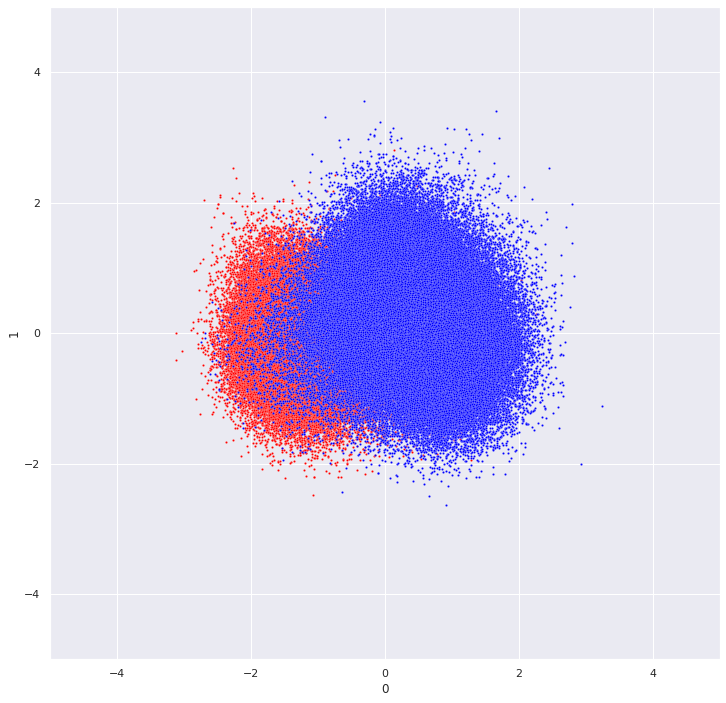

In [25]:
sns.scatterplot(x='0', y='1', data=men_embeddings, color='red', s=5).set(xlim=(-5,5),ylim=(-5,5))
sns.scatterplot(x='0', y='1', data=women_embeddings, color='blue', s=5).set(xlim=(-5,5),ylim=(-5,5))